### HCP Gambling - rfMRI analysis

This analysis aims to show whether the ACT-R models prediction (declarative model vs. RL modle) could also predict resting state brain connectivity

In [1]:
from __future__ import division
from lasso_func import *

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%reload_ext ipycache
#%%cache -d __pycache__ ipynb_cache.pkl

/home/chery/.conda/envs/pyactr/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# quick mode
skip = True

In [3]:
power2011 = pd.read_csv('../bin/power_2011.csv', usecols=["ROI", "X", "Y", "Z", "Network", "Color", "NetworkName"]) 

# convert to 1/0 dummy variable 
model_dat = pd.read_csv('../actr-models/model_output/MODELLogLikelihood.csv')
model_dat['best_model1'] = np.where(model_dat['best_model']== 'm1', 1, 0)

---
### Load Subj Cocountivty Matrix

We will load **partial correlation**.  By default, the `znorm=True` is enabled, so the corr matrix is normalized to z scores using the Fisher transformation


First, let's compare different correlation matries(z transformed)

- raw: not regress out motion artifacts
- mr: motion regression
- r: peaerson correlation matrix
- pr: partial correlation


Next, convert many connectivity matries into a wide matrix `subj_wide`, with a dimension of `N`(number of subjects) x `M` (264 x 264 = 69696)

In [4]:
subj_wide = load_subj('./rest_corr/REST1/', model_dat)

In [5]:
# define dependent variable 
DV = 'best_model1' 

# check connectivity matrix
subj_wide.head()

,HCPID,best_model1,"[1, 1]","[1, 2]","[1, 3]","[1, 4]","[1, 5]","[1, 6]","[1, 7]","[1, 8]",...,"[264, 255]","[264, 256]","[264, 257]","[264, 258]","[264, 259]","[264, 260]","[264, 261]","[264, 262]","[264, 263]","[264, 264]"
0,100307_fnca,1,13.409398,2.927578,-1.155759,-0.364546,0.349128,-0.706564,-0.382160,-0.185347,...,0.380917,0.005753,-0.180743,0.185730,0.477866,0.510258,0.830888,0.525403,1.697611,13.409398
1,100408_fnca,0,13.173195,5.128008,0.055992,0.019525,0.188248,-0.411183,-0.143225,0.353459,...,0.587524,0.390754,-0.770321,1.757529,-0.335044,-0.654781,1.089288,0.712491,-0.055744,13.173195
2,101006_fnca,0,13.393281,2.519951,-0.023334,1.225502,-0.999146,-0.296588,0.436511,-0.705540,...,1.316779,-0.412703,-0.269309,1.149215,0.333278,-1.015045,0.209324,-0.100220,-0.582268,13.393281
3,101107_fnca,1,12.972720,1.587885,0.314036,0.439562,-0.269505,-0.262101,-0.208469,0.267290,...,0.421536,1.883586,0.256153,0.953700,0.566897,0.668422,-0.578750,-0.072562,-1.598544,12.972720
4,101309_fnca,1,13.302745,2.762681,-0.967252,0.882096,0.192618,-0.047981,0.062077,-0.356968,...,0.226812,-0.327721,0.176769,-0.624466,0.128368,-0.097595,0.227804,0.025823,0.394443,13.302745


And now, let’s visualize the histogram of the dependent variable we are trying to predict:

In [ ]:
ax = sns.countplot(DV, data=subj_wide)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:d}'.format(p.get_height()), (x.mean(), y), 
                ha = 'center', va = 'bottom')

plt.xlabel('ACT-R Model')
plt.ylabel('Number of Participants')
plt.title("The Distribution of Individuals Best Fit by ACT-R Models")
plt.gca().set_xticklabels( ('RL Model\n(model2)', 'Declarative Model\n(model1)') )
plt.gca().invert_xaxis()
plt.show()

print('DV distribution:\n', subj_wide[DV].value_counts(normalize=False))

Imbalance training data might bias the logistic model, so we need to upsample the minority class by randomly adding more data from minrority class

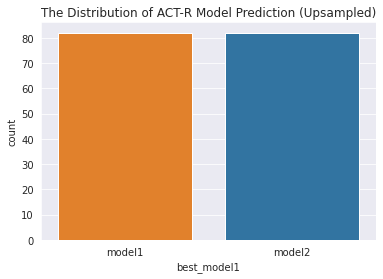

DV distribution:
 0    82
1    82
Name: best_model1, dtype: int64


In [7]:
subj_balance = balance_training_sample(subj_wide, DV)
sns.countplot(DV, data=subj_balance)
plt.title("The Distribution of ACT-R Model Prediction (Upsampled)")
plt.gca().set_xticklabels( ('model2', 'model1') )
plt.gca().invert_xaxis()
plt.show()

print('DV distribution:\n', subj_balance[DV].value_counts(normalize=False))

### Define Brain Region of Interest

Exclude some brain regions if necessary. 

Now, we obtain connectivity vector for NOI by combining `censor` with `subj_censored`

In [8]:
# define network of interest (NOI)
NOI = [
        "Uncertain",
        "Sensory/somatomotor Hand",
        "Sensory/somatomotor Mouth",
        "Cingulo-opercular Task Control",
        "Auditory",
        "Default mode",
        "Memory retrieval?",
        "Ventral attention",
        "Visual",
        "Fronto-parietal Task Control",
        "Salience",
        "Subcortical",
        "Cerebellar",
        "Dorsal attention"
]


In [9]:
censor = get_vector_df(power2011, NOI)        # filter some region connections
subj_censored = get_subj_df(subj_balance, censor)

features = list(subj_censored.columns)[2:]
print('The dimension of subj_censored is', subj_censored.shape, 'N = subj (upsampled), M = connections')

The dimension of subj_censored is (164, 34718) N = subj (upsampled), M = connections


In [10]:
subj_censored.head()

,HCPID,best_model1,"[1, 2]","[1, 3]","[1, 4]","[1, 5]","[1, 6]","[1, 7]","[1, 8]","[1, 9]",...,"[260, 261]","[260, 262]","[260, 263]","[260, 264]","[261, 262]","[261, 263]","[261, 264]","[262, 263]","[262, 264]","[263, 264]"
0,100307_fnca,1,2.927578,-1.155759,-0.364546,0.349128,-0.706564,-0.382160,-0.185347,0.109420,...,1.645303,1.562680,0.042960,0.510258,0.477527,0.504677,0.830888,-0.119521,0.525403,1.697611
1,101107_fnca,1,1.587885,0.314036,0.439562,-0.269505,-0.262101,-0.208469,0.267290,-0.297361,...,-0.286481,0.733278,2.719848,0.668422,0.452153,0.625449,-0.578750,-0.342575,-0.072562,-1.598544
2,101309_fnca,1,2.762681,-0.967252,0.882096,0.192618,-0.047981,0.062077,-0.356968,-0.678636,...,0.050288,0.842355,0.186935,-0.097595,0.689253,-0.087479,0.227804,0.266090,0.025823,0.394443
3,101915_fnca,1,6.971472,0.328180,0.413967,-0.276528,-0.295875,-0.253595,-1.124222,0.769258,...,0.510149,2.086726,0.112231,0.150957,0.660054,0.638516,0.100481,0.228162,-0.383715,0.020302
4,102311_fnca,1,2.093494,-0.636724,0.524422,-0.323236,-0.802873,-0.007528,0.157790,-0.570793,...,0.482339,-0.220328,1.108345,-1.546814,0.340663,0.839372,1.438210,-0.199391,-0.714049,0.259299


---

### Logistic Regression Models

Here, we will use logistic regression with L1 penalty (LASSO) to identify the functional connectivity patterns that predict the ACT-R model outcome variable `best_model`: model1 / model2. To better fit in logistic model, this variable is changed to `best_model1` =  1/0


### Split training data and Testing set.

We will use cross-validation method (cv=10) OR leave-one-out(LOO) to find best L1 parameter `lambda`

In [11]:
### 90% split
train_data, test_data = train_test_split(subj_censored, test_size=0.1, random_state=1)  

print('The dimension of train_data', train_data.shape)
print('The dimension of test_data', test_data.shape)

The dimension of train_data (147, 34718)
The dimension of test_data (17, 34718)


### Grid-Search HyperParameter (lambda) Tunning

Next, let's find the best `lambda_values` for Lasso Regression using grid search hyperparameter tunning

Visualize the  `lambda` and `coef_` path

- Method1: Standard Grid Search

- Method2: Random Grid Search (more efficient)

- Method3: Halving Grid Search (even more efficient, but may not accurate)

In [15]:
%%cache ipynb_cache.pkl grid_result score_df

plt.rcParams.update({'font.size': 40})
method = 'standard_gs'
######lambda_range = 1.0/np.logspace(-3, 3, 100)

if method == 'standard_gs':
    # standar GS is too slow (400s +)
    grid_result = grid_search_lasso(subj_censored, features, DV, num_cv=10, plot_path=True)
    #score_df = plot_regularization_score(subj_censored[features], subj_censored[DV])
    
elif method == 'random_gs':
    # random GS (200s +)
    grid_result = random_grid_search_lasso(subj_censored, features, DV, num_cv=20, plot_path=True)
    _ = plot_regularization_score(grid_result)
    
elif method == 'halving_gs':
    # halving GS (100s +)
    grid_result = halving_search_lasso(subj_censored, features, DV, plot_path=True)
    _ = plot_regularization_score(grid_result)

Best Score: 0.9518382352941177
Best Hyperparameters: {'C': 0.93260334688322}
Time usage: 857.082s
Time usage: 271.322s


KeyboardInterrupt: 

ValueError: Variable(s) 'score_df' could not be found in the interactive namespace

In [ ]:
score_df

In [ ]:
grid_search

In [102]:
def plot_regularization_score(X, y, lambda_range=None):
    start = time.time()
    if lambda_range == None: lambda_range = np.logspace(-3, 3, 100)
    param_range = 1.0/lambda_range
    
    model = LogisticRegression(penalty='l1', solver='saga', fit_intercept=False)
    train_scores, test_scores = validation_curve(model, X, y, param_name='C', error_score='raise', cv=2,
                                                 param_range=param_range, scoring="roc_auc", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    score_df = pd.DataFrame({'train_scores_mean':train_scores_mean, 'train_scores_std':train_scores_std,
                             'test_scores_mean':test_scores_mean, 'test_scores_std':test_scores_std,
                             'lambda_range':lambda_range,})
    score_df['best_lambda'] = lambda_range[np.argmax(test_scores_mean)]
    
    fig, ax = plt.subplots()
    plt.title("Logistic Regression: Cross-Validation Score")
    plt.xlabel(r"$\lambda$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2

    ax.semilogx(lambda_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    ax.fill_between(lambda_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    ax.semilogx(lambda_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    ax.fill_between(lambda_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    ax.axvline(best_lambda, linestyle='--', color='k')
    ax.text(x=best_lambda, y=0.7, s='best lambda\n{:.2e}'.format(best_lambda), color='k', fontsize=12,
            #transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    plt.legend(loc="best")
    plt.show()
    
    print('Time Usage: (s)', time.time()-start)
    return score_df

def plot_regularization_score(score_df):
    lambda_range = score_df['lambda_range']
    train_scores_mean = score_df['train_scores_mean']
    train_scores_std = score_df['train_scores_std']
    test_scores_mean = score_df['test_scores_mean']
    test_scores_std = score_df['test_scores_std']
    best_lambda = lambda_range[np.argmax(test_scores_mean)]
    
    
    fig, ax = plt.subplots()
    plt.title("Logistic Regression: Cross-Validation Score")
    plt.xlabel(r"$\lambda$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2

    ax.semilogx(lambda_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    ax.fill_between(lambda_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    ax.semilogx(lambda_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    ax.fill_between(lambda_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    ax.axvline(best_lambda, linestyle='--', color='k')
    ax.text(x=best_lambda, y=0.7, s='best lambda\n{:.2e}'.format(best_lambda), color='k', fontsize=12,
            #transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    plt.legend(loc="best")
    plt.show()
    

Time Usage: (s) 100.20085120201111


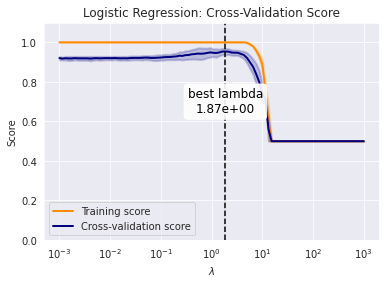

In [103]:
plot_regularization_score(score_df)

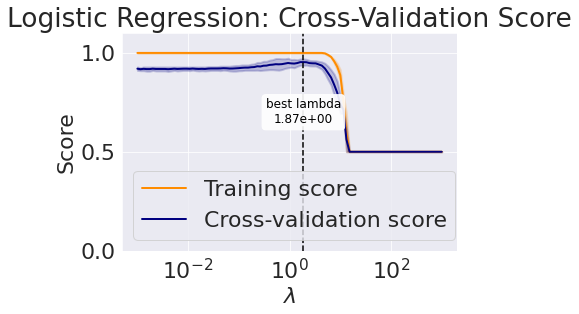

In [107]:
#%%cache -r ipynb_cache.pkl score_df
plt.rcParams.update({'font.size': 22})
plot_regularization_score(score_df)

### Re-Train Logistic Model

Next, we need to retrain the logistic model with best `lambda` 


In [19]:
best_C = grid_result.best_params_['C']
print('best lambda', 1.0/best_C)

best_lasso_model = LogisticRegression(penalty='l1', solver='saga', C=best_C, fit_intercept=False)
best_lasso_model.fit(subj_censored[features], subj_censored[DV])

best lambda 2.6826957952797272


LogisticRegression(C=0.3727593720314938, fit_intercept=False, penalty='l1',
                   solver='saga')

-  Method1: Leave-One-Out: Applying the leave-one-out(LOO) method, we can evaluate the accuracy, ROC, and confusion matrix


- Method2 Cross-Validation (20): If LOO method is tom computationally expensive, try cross-validation = 20

In [20]:
method = 'loo'

if method == 'loo':
    # LOO is computationally expensive (400s +)
    all_ytrue, all_yhat, all_yprob = loocv_logistic_retrain(subj_censored, features, DV, best_C)
    print('The Leave-One-Out Accuracy Score: {:.4f}'.format(accuracy_score(all_ytrue, all_yhat)))

elif method == 'cv20':
    # CV = 20 is more efficient (200s +)
    all_ytrue, all_yhat, all_yprob, _ =cv_logistic_retrain(subj_censored, features, DV, best_C, 2)
    print('The Cross-Validation(20) Accuracy Score: {:.4f}'.format(accuracy_score(all_ytrue, all_yhat)))
    

KeyboardInterrupt: 

In [ ]:
plot_roc_curve_loo(all_ytrue, all_yprob)

In [ ]:
plot_confusion_matrix_loo(subj_censored[DV].values, all_yhat)

Let's look at strongest connections and the beta dataframe

In [ ]:
betas = best_lasso_model.coef_[0]

min_connID = None
min_beta = betas[0]

max_connID = None
max_beta = betas[0]
for i in range(0, len(betas)):
    if betas[i] < min_beta:
        min_beta = betas[i]
        min_connID = features[i+1]
    if betas[i] > max_beta:
        max_beta = betas[i]
        max_connID = features[i+1]

print('min_beta', min_connID, min_beta)
print('max_beta',  max_connID, max_beta)

In [ ]:
beta_df = pd.DataFrame({'connID':features, 'beta':best_lasso_model.coef_[0]})
total_bata, _ = beta_df.shape
survived_bata, _ = beta_df[beta_df['beta']!=0.0].shape

print('Total beta:', total_bata, '\nSurvive bata:', survived_bata, '\nPercentage', round(survived_bata/total_bata, 4))

### Prediction vs. Observed


Next, let's see the predict_proba vs. observation labels

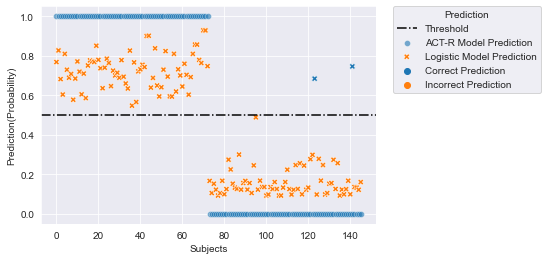

In [58]:
_ =plot_prediction_loo(all_ytrue, all_yhat, all_yprob, threshold=0.5)

### Brain Mapping

Next, look at the beta value mapped on brain 

TODO: calculate average brain corr matrix of all subjects (or weighted) and calculate `beta x averaged corr matrix` Plot new matrix?

In [59]:
adj_beta, power_coords = map_beta(censor, best_lasso_model.coef_[0], power2011)

The beta distribution

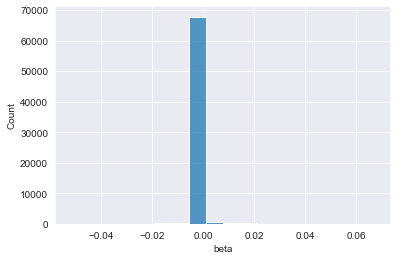

In [61]:
sns.histplot(data=pd.DataFrame({'beta':matrix2vector(adj_beta)}), x='beta')
plt.show()

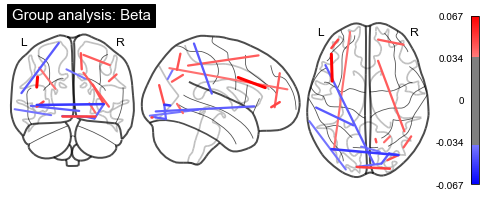

In [62]:
# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(adj_beta, power_coords,
                         edge_threshold='99.95%',
                         node_color='black',
                         colorbar=True,
                         node_size=0,
                         alpha=.2,
                         title='Group analysis: Beta')
plt.show()


In [63]:
plotting.view_connectome(adj_beta, power_coords, 
                         edge_threshold='99.95%',
                         colorbar=True,
                         node_size=1,
                         title='Group analysis: Beta').open_in_browser()

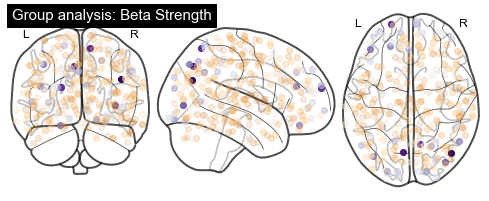

In [64]:
plotting.plot_connectome_strength(adj_beta, power_coords,
                         cmap = 'PuOr',
                         title='Group analysis: Beta Strength')

plotting.show()

In [237]:
#beta = pd.read_csv('./bin/example_beta_matrix.csv')

In [238]:
#adj_beta.replace(0, np.nan, inplace=True)
#adj_beta.to_csv('./bin/example_betaz_matrix.csv')

### Average Corr Matrix across Subjects

- STEP1: transform each of the `r` to Fisher's `z`
- STEP2:  average these `z` values
- STEP3: `mean_z` is back-transformed to `mean_r`

In [73]:
load_bata = False

if load_bata:
    beta_mat = pd.read_csv('./bin/example_beta_matrix.csv', header=0, index_col=0)
    beta_mat.fillna(0, inplace=True)
else:
    beta_mat = adj_beta.copy()

# calcualte beta * averaged PR   
subj_mean_mat = average_corr(subj_wide, DV)
subj_mean_mat = pd.DataFrame(subj_mean_mat, columns=beta_mat.columns)
adj_mat = beta_mat * subj_mean_mat

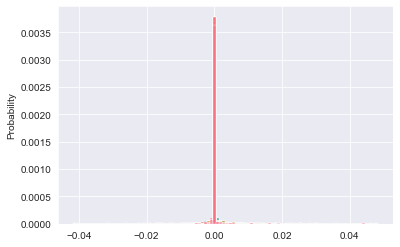

In [74]:
sns.histplot(np.array(adj_mat), legend=False, bins=100, stat='probability')
plt.show()

In [75]:
power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

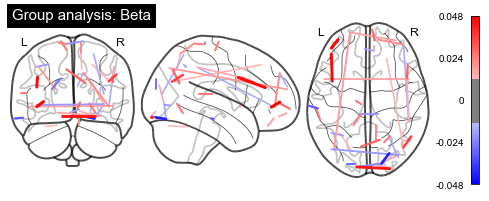

In [80]:
# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(adj_mat, power_coords, 
                         edge_threshold='99.9%',
                         #node_color=,
                         colorbar=True,
                         #cmap='Set2',
                         node_size=0, # size 264
                         #alpha=.2,
                         title='Group analysis: Beta')
plt.show()

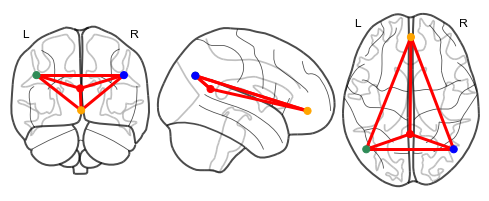

In [58]:
coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
adj_matrix = np.ones((4, 4))
plotting.plot_connectome(adj_matrix, coords, node_color=["red", "seagreen", "blue", "orange"])